In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

***derivative*** : if you slightly bump up input by delta h, how does the function respond?



In [8]:
def f(x):
  return 3*x**2 - 4*x + 5

def test_rise_over_run(x, h):
  numerator = (f(x + h) - f(x)) # how much did the function respond
  return (f(x + h) - f(x))/h # rise over run == slope
test_rise_over_run(x = 3.0, h = 0.001)

14.00300000000243

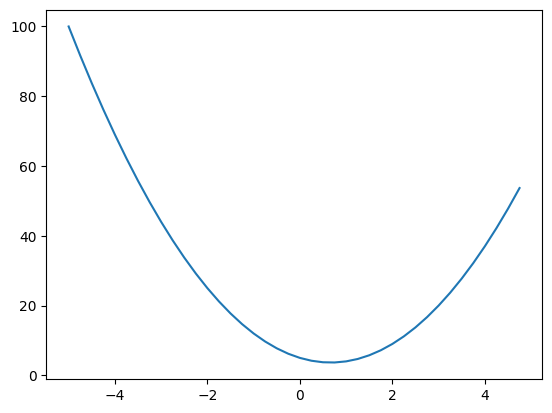

In [9]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [10]:
# how about slope at -3?

test_rise_over_run(x = -3.0, h = 0.001)

-21.996999999998934

In [12]:
# more complex
def a_slightly_more_complex_gradient():
  #inputs
  h = 0.001
  a = 2.0
  b = -3.0
  c = 10.0

  d1 =a*b + c
  print(d1)

  # ---------------------------- derivate of d, wrt a

  a += h
  d2 = a*b + c
  print('d1:', d1)
  print('d2: ', d2)
  # before we compute the slope, let's build an intuition
  # how do we expect the value of d2 to behave if we are bumping a?
  # we expect that d2 will be less than d1, given the presence of b which amplifies the negativity of the expression

  # what does this tell us about the slope?
  # increasing the input by a small margin, reduces our output value, which means our slope at input is facing down slanted towards the right (shape like = \)
  # so the slope should be negative

  #slope
  slope = (d2 - d1)/h
  print('slope wrt a:', slope)

  # --------------------------- what about the derivative wrt b?

  # mathematically, the derivative of the function wrt b is a, which is a positive number. so if we increase b by delta, our function should increase (be more than 4)

  #re-init inputs
  a = 2.0
  b = -3.0
  c = 10.0

  d1 =a*b + c
  print(d1)

  # derivate of d, wrt b
  b += h
  d2 = a*b + c
  print('d1:', d1)
  print('d2: ', d2)

  #slope
  slope = (d2 - d1)/h
  print('slope wrt b:', slope)

a_slightly_more_complex_gradient()
  # mathematically, the derivative of d wrt a is b. and b is negative 3, which is what we get using rise over run above

4.0
d1: 4.0
d2:  3.997
slope wrt a: -3.0000000000001137
4.0
d1: 4.0
d2:  4.002
slope wrt b: 1.9999999999997797


In [56]:
# let's now build an intuition for neural networks
# we need to understand how auto grad works
"""
Forward pass creates a new node and a closure that remembers the inputs (we can think of this as pointers to the children).
In __add__, we do:
  out = Value(self.data + other.data, (self, other), '+')
  def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
  out._backward = _backward

That _backward is a closure that holds references to three objects: self, other, and out. They’re the same Value instances we used to create out.


Later, during backprop, when we call _backward, Python resolves self and other (their pointers) from the closure’s captured environment.
Because Value instances are mutable, self.grad += ... directly updates the original nodes’ gradients.

We used += because a node can feed into multiple parents (fan-out). Gradients from multiple paths must sum (chain rule over a DAG).

Each operation creates a new node (out) and installs a "_backward" that knows how to push "out.grad" into its own inputs (self, other).
Nodes don’t coordinate horizontally; the graph structure and topo order handle the orchestration.
"""

'\nForward pass creates a new node and a closure that remembers the inputs (we can think of this as pointers to the children).\nIn __add__, we do:\n  out = Value(self.data + other.data, (self, other), \'+\')\n  def _backward():\n      self.grad += 1.0 * out.grad\n      other.grad += 1.0 * out.grad\n  out._backward = _backward\n\nThat _backward is a closure that holds references to three objects: self, other, and out. They’re the same Value instances we used to create out.\n\n\nLater, during backprop, when we call _backward, Python resolves self and other (their pointers) from the closure’s captured environment. \nBecause Value instances are mutable, self.grad += ... directly updates the original nodes’ gradients.\n\nWe used += because a node can feed into multiple parents (fan-out). Gradients from multiple paths must sum (chain rule over a DAG).\n\nEach operation creates a new node (out) and installs a "_backward" that knows how to push "out.grad" into its own inputs (self, other).\nNo

In [111]:
# in python, we need to use double underscores to define operators on the class
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0 # at init, the value doesn't affect the output
    self._backward = lambda: None # default is that it is a function that does nothing

  def __repr__(self):
    return f"Value(data={self.data},label={self.label},op={self._op})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # assuming that if other is not a value, it is numeric
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad # we are adding to the grad here because self.grad can be updated from multiple upstream nodes and we need to account for all those linkages
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # other * self, python falls back to this if it can't do self * other
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) # assuming that if other is not a value, it is numeric
    out = Value(self.data*other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  # a * 2 works because python maps it to a.__mul__(2)
  # 2 * a doesn't work because python maps it to 2.__mul__(a) and __mul__ is not defined on integers
  # to get around this, we create rmul, which is the fallback python uses if it can't find __mul__ when computing 2 * a
  # at that point it calls a.__rmul__(2)
  # the same concept holds true for __radd__
  def __rmul__(self, other):
    return self * other

  # other is the power by which self is called
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting integers and floating points"
    out = Value(self.data ** other, (self, ), f'**{other}')
    def _backward():
      self.grad = (other * self.data ** (other - 1)) * out.grad

    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  # self - other
  def __sub__(self, other):
    return self + (-other)

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad = out.grad * out.data # chain rule
    out._backward = _backward
    return out

  def __truediv__(self, other): # self / other
    return self * (other**-1) # a / b = a * (1 / b) = a * ( b ** -1)

  def tanh(self):
    t = (math.exp(2 * self.data) - 1)/ (math.exp(2 * self.data) + 1)
    out = Value(t, (self, ), 'tanh'  )
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    # ---- start backprop
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [112]:
a = Value (2.0)
a + 1
1 + a # works because we added radd

Value(data=3.0,label=,op=+)

In [113]:
a = Value (2.0)
a * 3
3 * a # works because we added rmul

Value(data=6.0,label=,op=*)

In [114]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5,label=,op=*)

In [115]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0,label=,op=+)

In [116]:
# let's now build a connection graph between these values

In [117]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR is left to right
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{%s | data %.4f  | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
      dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

In [118]:
# we now do backprop
# derivative of L (loss function) wrt to other nodes
# in NN, we are interested in the derivative of this loss function against neuron weights in the network

In [80]:
# first step: what's the derivative of L wrt L?

def manually_computing_derivaties():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c;  d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data
  print("L1: ", L1)

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c');
  e = a*b; e.label = 'e'
  d = e + c;  d.label = 'd'; d.data
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data + h
  print("L2: ", L2)
  print((L2 - L1)/h)

manually_computing_derivaties()
# we can modify the above function to get the derivate of L wrt to something else like 'a'. we only need to bump up 'a' by 'h'

L1:  -8.0
L2:  -7.999
1.000000000000334


In [120]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label ='x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.88137, label = 'b')

#x1w1 + x2w2 + b

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

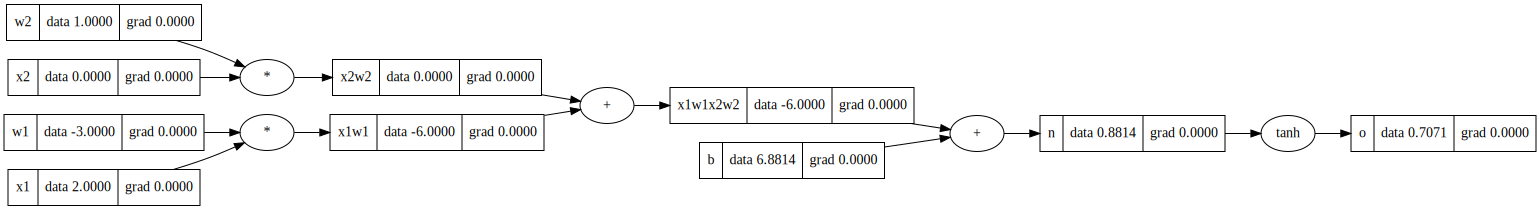

In [121]:
draw_dot(o)

In [122]:
# now we'll do backprop which means we'll compute the derivative of 'o' wrt to our input weights
# the weights change as part of the optimization
# DON'T RUN THIS CELL IF WE ARE TRYING TO GO AUTO BACKPROP
def mental_backprop():
  o.grad = 1.0
  n.grad = 1 - o.data**2 # 0.5
  b.grad = 0.5
  x1w1x2w2.grad = 0.5

  x1w1.grad = 0.5
  x2w2.grad = 0.5
  w1.grad = 1.0
  w2.grad = 0
  x1.grad = -1.5
  x2.grad = 0.5
# not calling this function as it has been replaced by auto backprop below
# mental_backprop()

In [123]:
# automatically do backprop (just a tad bit)
def slight_auto_backprop():
  o.grad = 1.0 # init to avoid all 0 values since grad is initialized as 0
  o._backward()
  n._backward()
  b._backward() # leaf var
  x1w1x2w2._backward()
  x1w1._backward()
  x2w2._backward()
# not calling this method as we have made the backprop fully automated
# slight_auto_backprop()

In [124]:
# now, instead of calling backward manually for every node, we'd want to automate it.

# for this, we'll go a topological sort, starting from the end node ('o').
# the code is now moved to the Value class

o.backward()

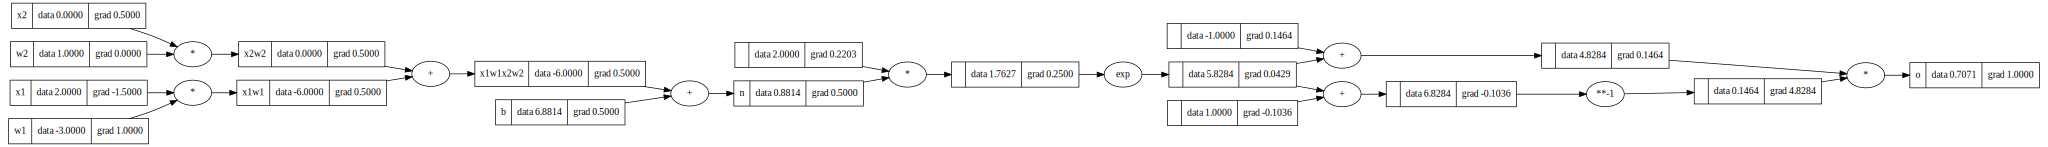

In [125]:
# we'll now break tanh into smaller chunks

# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label ='x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.88137, label = 'b')

#x1w1 + x2w2 + b

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----------
e = (2 * n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [126]:
# we'll now see how we can do this with pytorch !!!!!

In [127]:
import torch

In [128]:
# sample tensor
torch.Tensor([[1,2,3], [4,5,6]]).shape

torch.Size([2, 3])

In [129]:
torch.Tensor([2.0]).shape

torch.Size([1])

In [130]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.88137]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)
print(o.data.item())
o.backward()

print('----')
print('x2 ', x2.grad.item())
print('w2 ', w2.grad.item())
print('x1 ', x1.grad.item())
print('w1 ', w1.grad.item())




0.7071050214706146
----
x2  0.5000024886110417
w2  0.0
x1  -1.500007465833125
w1  1.0000049772220834


In [131]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [171]:
import random

class Neuron:
  def __init__(self, nin): # nin = number of inputs to this neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1)) # trigger happiness of this neuron
  def __call__(self, x):
    # intent: w*x + b where the first part is a dot product
    # zip takes two iterators, creates a new iterator that has tuples of corresponding entries
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  def parameters(self):
    return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)


Value(data=0.9852347986729847,label=,op=tanh)

In [173]:
class Layer:
  # nout = number of neurons we want in our layer
  # nin = number of inputs we have, stays the same for each neuron
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  # gather all learnable params from each neuron into one flat lis
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.8814482289927231,label=,op=tanh),
 Value(data=-0.8709570235661542,label=,op=tanh),
 Value(data=0.9848478142996293,label=,op=tanh)]

In [176]:
class MLP:
  # nin = number of inputs
  # nouts = a list of number of neurons in a layer. the list defines the sizes of all layers we want in the MLP
  def __init__(self, nin, nouts):
    sz = [nin] + nouts # concatenates lists, if nin = 3 and nouts = [16, 16, 1], then sz = [3, 16, 16, 1]
    # first layer has shape 3 * 16 (ins * outs)
    # second layer has shape 16 * 16
    # rthird layer has shape 16 * 1
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
n.parameters()

In [266]:
# re-init MLP
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6322211505734971,label=,op=tanh)

In [ ]:
draw_dot(n(x))

In [267]:
# four possible inputs
xs = [

      [2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]

  # we'll now use the loss function to push each y-value closer to the desired target
  # mean squared error loss
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  # zero grad before backward pass
  for p in n.parameters():
    p.grad = 0

  # now do the backward pass
  loss.backward()

  # update params
  # gradient is a vector pointing in the direction of increased loss
  for p in n.parameters():
    p.data += -0.01 * p.grad # 0.01 is the learning rate

  print(k, loss.data, )

In [ ]:
draw_dot(loss)

In [ ]:
ypred